# PySCF Interface

## Overview

The PySCF Interface module allows for direct extraction of Hamiltonian, overlap matrices, and density matrices from [PySCF](https://pyscf.org/) (Python simulations of chemistry framework) calculations into the DeepH format. 

Unlike the file-based converters for OpenMX and SIESTA, the PySCF interface operates **dynamically within Python**. It can "hook" into a running PySCF calculation to extract data on-the-fly, or process a standard PySCF mean-field object after calculation.

This makes it particularly powerful for:
- Building automated dataset generation pipelines entirely in Python.
- Handling both molecular (GTO) and periodic (PBC) systems with a unified API.
- Flexible control over k-point sampling for dataset generation.

**Note**: This compute module is designed for PySCF version 2.11.0. Since PySCF is a Python library and not a standalone executable with standardized output files, this interface **does not support the command-line (CLI) `dock convert` workflow**. Instead, it provides a simple **Python Class API** `deepx_dock.compute.pyscf.pyscf2deeph.PySCFDataHooker`.

## File Structure Organization

### PySCF Data Structure
Since PySCF **does not natively** support directly outputting the Hamiltonian matrix and the overlap matrix, but instead relies on `mf.dump()` to output quantities related to the density matrix, it is therefore impossible to obtain the Hamiltonian and overlap matrices by parsing the output files.

Therefore, the file structure of the stored calculation output is not required here; instead, the API needs to be invoked at the beginning or end of a single calculation so that, after the computation is completed, the corresponding physical quantities can be **read directly from memory** and parsed.

### DeepH Data Structure
```bash
deeph_datasets/
├── structure_1/
│   ├── info.json
│   ├── POSCAR
│   ├── hamiltonian.h5      # Exported by default
│   ├── overlap.h5          # Exported by default
│   ├── density_matrix.h5   # Optional - requires export-rho=True
│   └── position_matrix.h5  # Not supported currently
├── structure_2/
│   └── ...
└── ...
```


## Key Features

1.  **Hook Mechanism**: Automatically collect data at the end of `mf.kernel()`.
2.  **Post-Calculation Dump**: Extract data from a converged mean-field object.
3.  **K-Point Interpolation**: Support exporting data on a denser k-point grid than used in the self-consistent calculation (via Wannier-like interpolation logic).
4.  **Overlap-Only Mode**: Rapidly generate overlap matrices for geometry-only tasks.

## Usage Method 1: The "Hook" Mechanism

The most straightforward way to use the interface is to wrap your PySCF mean-field object (`mf`) with `PySCFDataHooker` before running the calculation.

When you call `mf.kernel()`, the hook will:
1.  Run the standard PySCF calculation.
2.  Upon completion, automatically calculate and save the DeepH-formatted matrices to the specified directory.

**Parameters for `PySCFDataHooker`**:
-   `deeph_path` (str): Output directory.
-   `rcut` (float, optional): Global cutoff radius for local orbitals (in Angstrom).
    - if not provided, the default cutoff value from structure (`cell.rcut`) will be used.
    - **Note**: PySCF interface currently supports a single global `rcut` for all atoms.
-   `export_S` (bool): Export overlap matrix to `overlap.h5` (Default: True).
-   `export_H` (bool): Export Hamiltonian matrix to `hamiltonian.h5` (Default: True).
-   `export_rho` (bool): Export density matrix to `density.h5` (Default: False).

*Export position matrices not supported now.* 

In [ ]:
# Example: Molecular H2O (UKS - Unrestricted Kohn-Sham)
import os
from pyscf import gto, scf, dft

deeph_data_dir = '/tmp/deeph_data'

data_path = os.path.join(deeph_data_dir, "H2O_U")
## 1. Define Molecule
mol = gto.M(atom='O 0 .5 0; H -1.1 0.2 0.2; H 0.6 0.5 0.4',
            basis='cc-pvdz')
mol.verbose = 3
mol.spin = 2

## 2. Define Mean-Field Object
mf = dft.UKS(mol)
mf.xc = 'b3lyp'

In [ ]:
from deepx_dock.compute.pyscf.pyscf2deeph import PySCFDataHooker
## 3. Apply the Hook
# This "intercepts" the kernel call
mf = PySCFDataHooker(deeph_path=data_path, rcut=6.0)(mf)
## 4. Run Calculation
# Data will be saved to ./tmp/deeph_data/H2O_U automatically
mf.kernel()

Overwritten attributes  kernel  of <class 'pyscf.dft.uks.UKS'>
<class 'pyscf.dft.uks.UKS'> does not have attributes  is_hooked


converged SCF energy = -76.0480097905671  <S^2> = 2.0018022  2S+1 = 3.0012012


In [ ]:
# Example: Periodic MgO without spin (KRKS)
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
import pyscf.pbc.gto as pbcgto
import pyscf.pbc.dft as pbcdft
from ase.build import bulk

data_path = os.path.join(deeph_data_dir, 'MgO')
## 1. Setup Cell
c = bulk('MgO', 'rocksalt', a=4.212)

cell = pbcgto.Cell()
cell.atom = pyscf_ase.ase_atoms_to_pyscf(c)
cell.a = c.cell

cell.basis = 'gth-szv'
cell.pseudo = 'gth-pade'
cell.verbose = 3
cell.build(None,None)

In [ ]:
kmf = pbcdft.KRKS(cell, cell.make_kpts([5,5,5]))
## 2. Hook and Run
hooker = PySCFDataHooker(deeph_path=data_path, rcut=6.0)
kmf = hooker.hook_kernel(kmf)
kmf.kernel()

Overwritten attributes  kernel  of <class 'pyscf.pbc.dft.krks.KRKS'>
<class 'pyscf.pbc.dft.krks.KRKS'> does not have attributes  is_hooked
/public/home/mind/software/miniconda3/envs/pyscf/lib/python3.13/site-packages/pyscf/pbc/gto/cell.py:127: UserWarning: Function cell.dumps drops attribute a because it is not JSON-serializable
  warnings.warn(msg)


converged SCF energy = -79.1349891780751


Warn: The original fermi energy (12.205243245980116) is not in the band gap (14.728295236126927, 12.205415834419268), and it will be modified into the band gap.


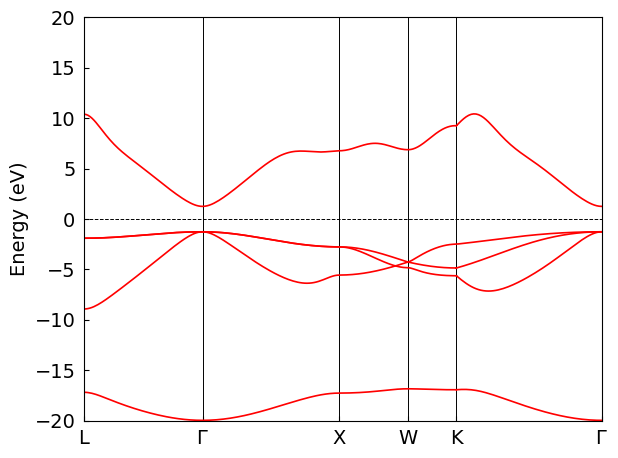

In [ ]:
## Band Structure Calculation and Plotting
from deepx_dock.compute.eigen.hamiltonian import HamiltonianObj
from deepx_dock.compute.eigen.band import BandDataGenerator, BandPlotter

band_conf = {
    "k_list_spell" : """
    60   0.5  0.5  0.5    0.0  0.0  0.0    L     Gamma
    60   0.0  0.0  0.0    0.5  0.0  0.5    Gamma X
    60   0.5  0.0  0.5    0.5  0.25 0.75   X     W
    60   0.5  0.25 0.75   0.375 0.375 0.75 W     K
    60   0.375 0.375 0.75 0.0  0.0  0.0    K     Gamma
    """
}
band_data_path = os.path.join(data_path, "band_data.h5")
window = [-20, 20]

obj_H = HamiltonianObj(data_path)
bd_gen = BandDataGenerator(obj_H, band_conf)
bd_gen.calc_band_data()
bd_gen.dump_band_data(band_data_path)
bd_plotter = BandPlotter(band_data_path)
bd_plotter.plot(*window)

## Usage Method 2: Post-Calculation Dump & Custom K-Points

If you have already run a calculation, or if you want to export data on a **different k-point grid** than the one used for the SCF convergence, you can use the `.dump()` method.

This is particularly useful for periodic systems where you might run SCF on a coarse grid (e.g., 2x2x2) but generate training data on a denser grid (e.g., 5x5x5) to capture more detailed band structure information without re-running the costly SCF loop.

**Note**: 
- When `dump()` is applied to already computed results, regardless of how the k-point sampling is set, it requires roughly the computational cost of one additional self-consistent iteration to evaluate the exported quantities. 
- Therefore, if the k-point density used for exporting is the same as that used in the original calculation, it is recommended to use the `hook_kernel()` method before the calculation to reduce the computational cost. If a denser k-point mesh is used for exporting, the `dump()` method can be employed.


**Parameters for `hook_kernel()` and `dump()`**:
-   `kpt` (list or tuple, optional): K-point grid for exporting data. If not provided, uses the original k-points from the mean-field object.
    - shape: `(3,)` representing the number of k-points along each reciprocal lattice vector, or `(N_kpts, 3)` for explicit k-point coordinates in **1/Bohr** (such as `cell.make_kpts()`).

**Important Note on K-Points**:
*   The `kpt` argument in `dump()` allows you to specify the target k-grid. 
*   This uses the converged density matrix to construct the Hamiltonian at new k-points.

In [ ]:
## 2. Run SCF on a coarse grid (2x2x2)
data_path = os.path.join(deeph_data_dir, 'MgO_2')
kmf = pbcdft.KRKS(cell, cell.make_kpts([2,2,2]))
kmf.kernel()
## 3. Dump data on a DENSE grid (5x5x5)
# Note: We initialize the hooker, but we call .dump() instead of wrapping the object
hooker = PySCFDataHooker(deeph_path=data_path, rcut=6.0)
# The 'kpt' argument defines the target grid (can be denser than SCF k-grid)
hooker.dump(kmf, kpt=[5,5,5])

converged SCF energy = -79.0718368768439


Warn: The original fermi energy (13.655161000039923) is not in the band gap (15.451583257116534, 13.655340410901571), and it will be modified into the band gap.


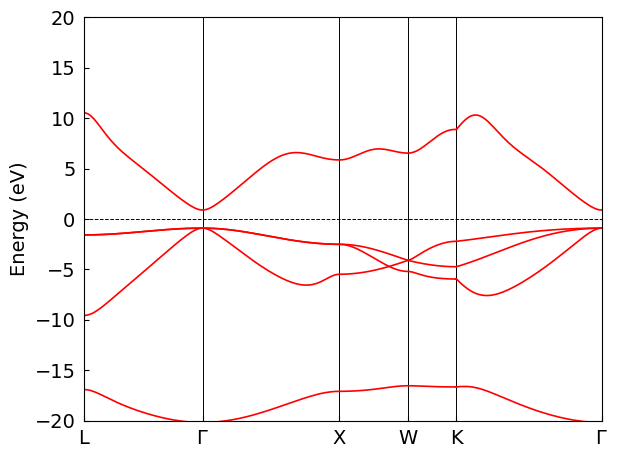

In [ ]:
band_data_path = os.path.join(data_path, "band_data.h5")

obj_H = HamiltonianObj(data_path)
bd_gen = BandDataGenerator(obj_H, band_conf)
bd_gen.calc_band_data()
bd_gen.dump_band_data(band_data_path)
bd_plotter = BandPlotter(band_data_path)
bd_plotter.plot(*window)

## Usage Method 3: Overlap Only

For some workflows (like constructing graph structures before electronic iterations or after inference of hamiltonians using machine learning models), you may only need the overlap matrix. The `dump_ovlp` method is optimized for this and skips Hamiltonian construction.

The parameters are similar to the full dump method, but only the overlap matrix is computed and saved.

In [ ]:
# Export ONLY the overlap matrix
output_path_ovlp = os.path.join(deeph_data_dir, 'MgO_2')
hooker_ovlp = PySCFDataHooker(deeph_path=output_path_ovlp, rcut=6.0)

# dump_ovlp can also accept a custom k-point grid
# Note: This runs very fast as it only loops over overlaps
hooker_ovlp.dump_ovlp(kmf, kpt=[5,5,5])

print(f"Overlap data generated at: {output_path_ovlp}")

In [ ]:
from pathlib import Path
print([str(v) for v in list(Path("/tmp/deeph_data").iterdir())])
print([str(v) for v in list(Path("/tmp/deeph_data/MgO").iterdir())])

['tmp/deeph_data/MgO', 'tmp/deeph_data/MgO_2', 'tmp/deeph_data/H2O_U']
['tmp/deeph_data/MgO/info.json', 'tmp/deeph_data/MgO/POSCAR', 'tmp/deeph_data/MgO/overlap.h5', 'tmp/deeph_data/MgO/band.png', 'tmp/deeph_data/MgO/hamiltonian.h5', 'tmp/deeph_data/MgO/band_data.h5']


## Important Considerations

### Global Cutoff Radius (`rcut`)
The `rcut` parameter in `PySCFDataHooker` defines the cutoff radius for determining the sparsity pattern of the Hamiltonian and overlap matrices (i.e., which atom pairs effectively interact).
*   **Current Limit**: Only a single global `rcut` is supported for all atom pairs.
*   Make sure `rcut` is large enough for your basis set convergence but small enough to maintain sparsity.

### K-Point Density
When exporting periodic data, you can specify a target `kpt` grid (e.g., `[5,5,5]`) that is distinct from the SCF mesh. This is useful for dataset generation.
*   **Density Warning**: If your target grid is significantly denser than what `rcut` can support (based on Shannon sampling theorem/Wannier interpolation limits), you may see warnings or artifacts.
*   Usually, `k_grid` density and `rcut` should be physically consistent with the localization of your basis functions.

### No Command Line Interface
As demonstrated, this module is strictly a Python API. There is no `dock convert pyscf ...` command because PySCF inputs are Python scripts themselves. Integration involves importing `PySCFDataHooker` directly into your calculation scripts.

---

*This compute module represents a key component in bridging dynamic quantum chemical simulations with modern machine learning approaches in materials science, enabling researchers to leverage the Python-native flexibility of PySCF for automated dataset generation in cutting-edge machine learning applications.*